In [2]:
import matplotlib_venn
import pandas as pd
import numpy as np
import requests
import warnings
import prettytable
import re
import textwrap as tw

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'FPL Neu'
%config InlineBackend.figure_formats = ['svg']

In [3]:
with open("Uniprot_ST_Kinases.xlsx", "wb") as st:
    r = requests.get("https://rest.uniprot.org/uniprotkb/stream?download=true&fields=accession%2Cid%2Cgene_primary%2Corganism_name%2Clength%2Creviewed&format=xlsx&query=%28%28keyword%3AKW-0723%29%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28model_organism%3A9606%29")
    if r.ok:
        st.write(r.content)

with open("Uniprot_Y_Kinases.xlsx", "wb") as y:
    r = requests.get("https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Cid%2Cgene_primary%2Corganism_name%2Clength%2Creviewed&format=xlsx&query=%28%28keyword%3AKW-0829%29%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28model_organism%3A9606%29")
    if r.ok:
        y.write(r.content)

In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=UserWarning, message="Workbook contains no default style")
    with open ("Uniprot_ST_Kinases.xlsx", "rb") as st:
        st_kinases = pd.read_excel(st)
    with open ("Uniprot_Y_Kinases.xlsx", "rb") as y:
        y_kinases = pd.read_excel(y)

In [5]:
all_uniprot = pd.concat([st_kinases, y_kinases], ignore_index=True).sort_values(by = ["Entry Name", "Gene Names (primary)"])[['Entry', 'Entry Name', 'Gene Names (primary)']].rename(columns={'Entry': 'Uniprot ID', 'Gene Names (primary)': 'Gene Name'}).reset_index(drop=True)

In [6]:
all_uniprot['Symbol'] = all_uniprot['Gene Name'] + "|" + all_uniprot['Uniprot ID']

In [31]:
psp_kinase_table = pd.read_excel("../../data/raw_data/Kinase_Substrate_Dataset_(Downloaded).xlsx").rename(columns={'GENE': 'Gene Name', 'KIN_ACC_ID': 'Uniprot ID', 'KIN_ORGANISM': 'Organism'}, inplace=False)[['Gene Name', 'Uniprot ID', 'Organism']].drop_duplicates(keep='first').reset_index(drop=True)

psp_kinase_table.to_csv("psp_kinase_table.csv", index=False)

In [7]:
psp_kinase_table = pd.read_csv("psp_kinase_table.csv")
psp_human_kinase_table = psp_kinase_table[psp_kinase_table['Organism'].apply(lambda x: x.lower()) == 'human']
psp_human_kinase_table['Symbol'] = psp_human_kinase_table['Gene Name'] + "|" + psp_human_kinase_table['Uniprot ID']

/tmp/ipykernel_15778/3759122584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psp_human_kinase_table['Symbol'] = psp_human_kinase_table['Gene Name'] + "|" + psp_human_kinase_table['Uniprot ID']


In [8]:
p = prettytable.PrettyTable(
    field_names=[
        "Uniprot or PSP?",
        "Total # of Entries",
        "# of Entires with Unq Symbol",
        "# of Uni ID Shared with Uniprot",
        "# of Uni ID Shared with PSP",
        "# of Uni ID Only in Uniprot",
        "# of Uni ID Only in PSP",
    ],
    max_width = 1
)


In [9]:
p.add_row(
    [
        "Uniprot",
        len(all_uniprot),
        len(all_uniprot["Symbol"].unique()),
        # len(all_uniprot[all_uniprot["Uniprot ID"].apply(lambda x: bool(re.match("^[OPQ].*", x, flags=re.IGNORECASE)))]),
        pd.NA,
        len(all_uniprot[all_uniprot["Uniprot ID"].isin(psp_human_kinase_table["Uniprot ID"])]),
        len(all_uniprot[~all_uniprot["Uniprot ID"].isin(psp_human_kinase_table["Uniprot ID"])]),
        pd.NA,
    ]
)

p.add_row(
    [
        "PSP",
        len(psp_human_kinase_table),
        len(psp_human_kinase_table["Symbol"].unique()),
        # len(
        #     psp_human_kinase_table[
        #         # psp_human_kinase_table["Uniprot ID"].apply(lambda x: bool(re.match("^[OPQ].*", x, flags=re.IGNORECASE)))
        #     ]
        # ),
        len(psp_human_kinase_table[psp_human_kinase_table["Uniprot ID"].isin(all_uniprot["Uniprot ID"])]),
        pd.NA,
        pd.NA,
        len(psp_human_kinase_table[~psp_human_kinase_table["Uniprot ID"].isin(all_uniprot["Uniprot ID"])]),
    ]
)


In [10]:
p

Uniprot or PSP?,Total # of Entries,# of Entires with Unq Symbol,# of Uni ID Shared with Uniprot,# of Uni ID Shared with PSP,# of Uni ID Only in Uniprot,# of Uni ID Only in PSP
Uniprot,500,477,<NA>,403,97,<NA>
PSP,427,427,382,<NA>,<NA>,45


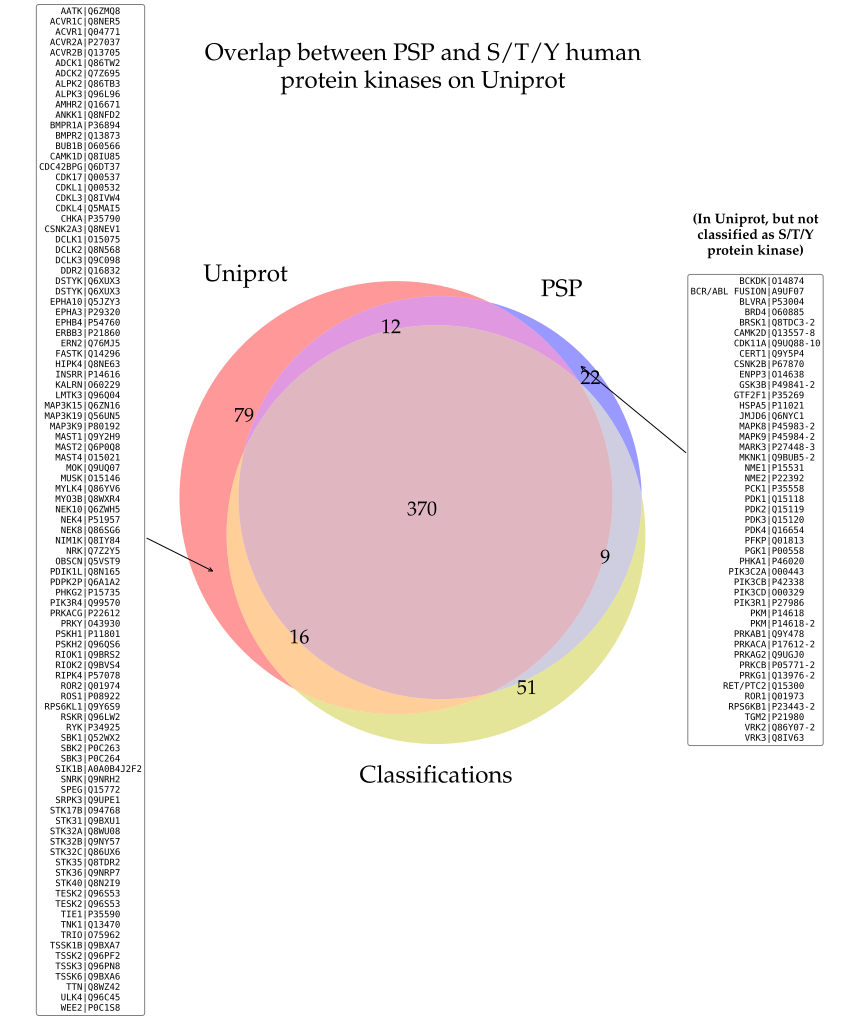

In [19]:
kfg = pd.concat([pd.read_csv("DeepKS/data/preprocessing/kin_to_fam_to_grp_5.csv"), pd.read_csv("DeepKS/data/preprocessing/kin_to_fam_to_grp_817.csv")])
remove_unip = lambda x: x.split("|")[0]
fig, ax = plt.subplots(figsize=(15, 15))
matplotlib.rcParams["font.size"] = 20
matplotlib_venn.venn3(
    subsets=[
        set(all_uniprot["Symbol"].apply(remove_unip).unique()),
        set(psp_human_kinase_table["Symbol"].apply(remove_unip).unique()),
        set(kfg["Kinase"])
    ],
    set_labels=("Uniprot", "PSP", "Classifications"),
    set_colors=("r", "b", 'y'),
    ax=ax,
)
for name, set_ in zip(["all_uniprot", "psp_human_kinase_table"], [psp_human_kinase_table, all_uniprot]):
    other_set: pd.DataFrame = locals()[name]
    annot = "\n".join(sorted(set_[~set_["Uniprot ID"].isin(other_set["Uniprot ID"])]["Symbol"].tolist())).upper()
    annot_L = [x.split("|")[0] for x in annot.split("\n")]
    annot_R = [x.split("|")[1] for x in annot.split("\n")]
    l_just_amt = max([len(x) for x in annot_L])
    r_just_amt = max([len(x) for x in annot_R])
    annot = "\n".join([f"{l:>{l_just_amt}}|{r:<{r_just_amt}}" for l, r in zip(annot_L, annot_R)])
    ax.annotate(
        annot,
        xy=(0.375, 0.35) if name == "all_uniprot" else (-0.5, -0.15) if name == "psp_human_kinase_table" else (0, 0),
        xytext=(0.8 * (1 if name == "all_uniprot" else -1), 0),
        fontsize=9,
        fontfamily="monospace",
        color="k",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round", fc="w", ec="k", lw=1, alpha=0.5),
        arrowprops=dict(dict(arrowstyle="->")),
    )

ax.annotate(
    tw.fill("(In Uniprot, but not classified as S/T/Y protein kinase)", 20),
    xy=(0, 0),
    xytext=(0.8, 0.66),
    fontsize=14,
    fontweight="bold",
    color="k",
    ha="center",
    va="center",
)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title(tw.fill("Overlap between PSP and S/T/Y human protein kinases on Uniprot", 40))
plt.savefig("./human_kinase_overlap.pdf", bbox_inches="tight")


In [12]:
import os
os.getcwd()
os.chdir("/home/ubuntu")